<a href="https://colab.research.google.com/github/Bmdhia/Dhia-Ben-Marzouk__Belt-Exam-A/blob/main/Belt_final_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
SEED = 321
np.random.seed(SEED)
pd.set_option('display.max_columns',100)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Import and init shap
import shap
shap.initjs()

In [ ]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True):
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))

    else:
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""

    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]

    if sort_values:
        coeffs = coeffs.sort_values()



    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()

    if top_n is not None:
        importances = importances.tail(top_n)


    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

### Part 1

In [ ]:
import joblib

# Load the joblib file
loaded = joblib.load("/content/saved_model.joblib")

# Display the keys of the dictionary
print("Keys:", loaded.keys())

Keys: dict_keys(['preprocessor', 'X_train', 'X_test', 'y_train', 'y_test', 'LinearRegression', 'RandomForestRegressor'])


In [ ]:
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

In [ ]:
feature_names = preprocessor.get_feature_names_out()

## Use the preprocessor to transform X_train into X_train_df
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

## Use the preprocessor to transform X_test into X_test_df

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)

In [ ]:
X_train_df.head()

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
853,16269.0,69.230685,5.0,907.0,907.0,5.0,1.0,0.0,0.0,0.0,1.0
1055,13891.0,107.000000,5.0,1710.0,1710.0,6.0,1.0,0.0,0.0,0.0,1.0
2483,8900.0,69.230685,4.0,1056.0,1056.0,5.0,1.0,0.0,0.0,0.0,1.0
2351,11475.0,85.000000,6.0,713.0,1552.0,6.0,1.0,0.0,0.0,0.0,1.0
1700,13654.0,118.000000,5.0,1704.0,2758.0,9.0,1.0,0.0,0.0,0.0,1.0


### Explain the Linear Regression Model:

In [ ]:
## Get the coefficients from the lin reg
coeffs = get_coefficients(lin_reg_final)
coeffs

Lot Area                0.107876
Lot Frontage          109.311338
Overall Cond         1737.313325
Total Bsmt SF          59.753976
Gr Liv Area           101.283754
TotRms AbvGrd       -6299.906977
Central Air_Y       31927.224382
Land Contour_Bnk   -72620.466486
Land Contour_HLS     4243.627305
Land Contour_Low   -43310.960673
Land Contour_Lvl   -42264.186316
intercept               0.000000
dtype: float64

In [ ]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [ ]:
coeffs

Lot Area                 0.11
Lot Frontage           109.31
Overall Cond         1,737.31
Total Bsmt SF           59.75
Gr Liv Area            101.28
TotRms AbvGrd       -6,299.91
Central Air_Y       31,927.22
Land Contour_Bnk   -72,620.47
Land Contour_HLS     4,243.63
Land Contour_Low   -43,310.96
Land Contour_Lvl   -42,264.19
intercept                0.00
dtype: float64

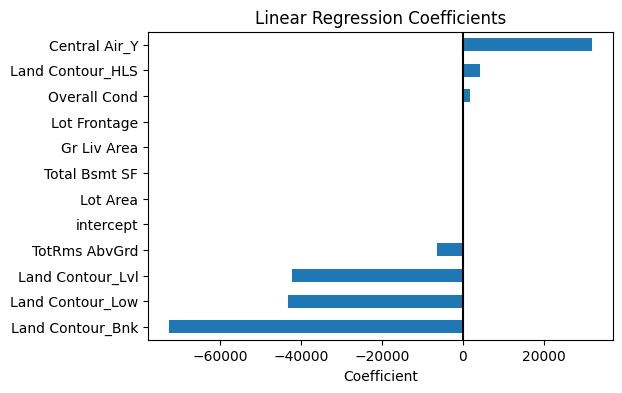

<Axes: title={'center': 'Linear Regression Coefficients'}, xlabel='Coefficient'>

In [ ]:
## plot the coefficients
plot_coefficients(coeffs)

Central Air_Y (31,927.22): Homes with central air tend to be worth about 31,927.22 more.


Overall Cond (1,737.31): If a home is in better overall condition, its value increases by around 1,737.31.


Land Contour_HLS (4,243.63): Houses on hillsides are predicted to be worth roughly 4,243.63 more.


Land Contour_Lvl (-42,264.19): Homes on level land are expected to be valued about 42,264.19 less.


Land Contour_Low (-43,310.96): Properties in low-lying areas are estimated to be worth approximately 43,310.96 less.


Land Contour_Bnk (-72,620.47): Houses near a bank are predicted to be significantly less valuable, with an estimated decrease of 72,620.47.

### Explain the Random Forest Model:


Split,R^2,MAE,RMSE
Train,0.97,"9,509.29","14,817.31"
Test,0.77,"23,217.21","35,317.36"


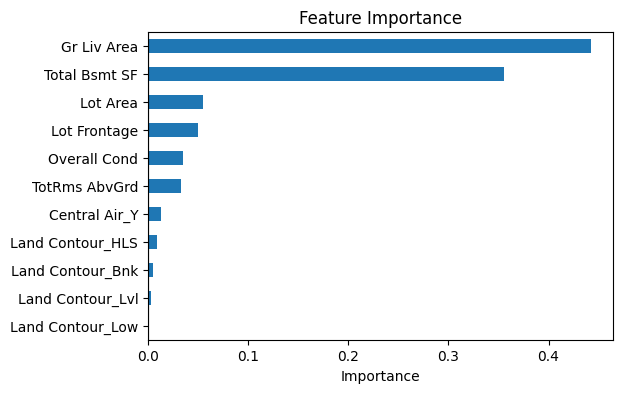

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [ ]:
## evaluate the random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances)

*  Gr Liv Area , total Bsmt SF , Lot Area , Lot Frontage , Ovreall Cond and TotRms AbvGrd are the top 6 most important features.

*  Ovreall Cond is the feature that appeard in the 3 largest or 3 smallest coefficients.

### Apply Shap to Explain the Random Forest Model


In [ ]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Lot Area,Lot Frontage,Overall Cond,Total Bsmt SF,Gr Liv Area,TotRms AbvGrd,Central Air_Y,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl
2605,"10,800.00",60.00,8.00,796.00,"1,466.00",7.00,1.00,0.00,0.00,0.00,1.00
2520,"3,874.00",40.00,5.00,"1,226.00","1,226.00",4.00,1.00,0.00,0.00,0.00,1.00
1251,"8,838.00",71.00,3.00,0.00,"1,764.00",7.00,1.00,0.00,0.00,0.00,1.00
2478,"7,153.00",65.00,5.00,761.00,"1,603.00",7.00,1.00,0.00,0.00,0.00,1.00
2108,"11,750.00",75.00,5.00,"1,546.00","1,546.00",7.00,1.00,0.00,0.00,0.00,1.00


In [ ]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

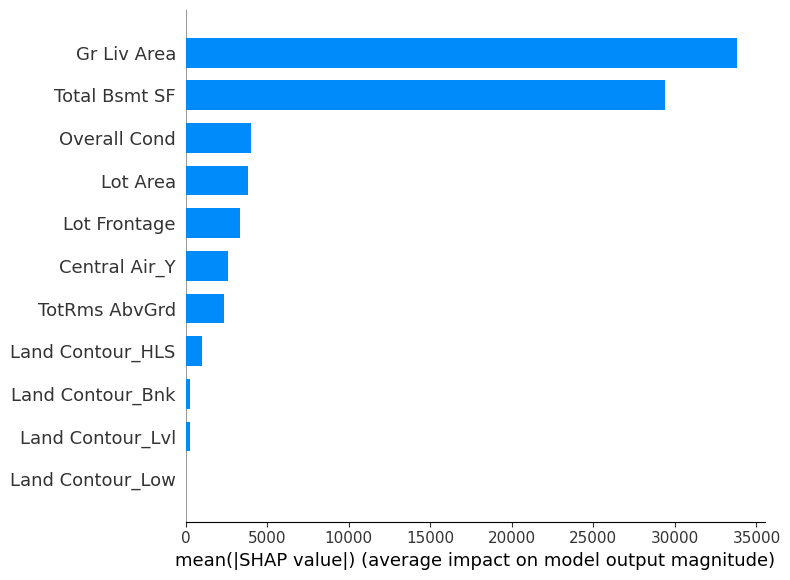

In [ ]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

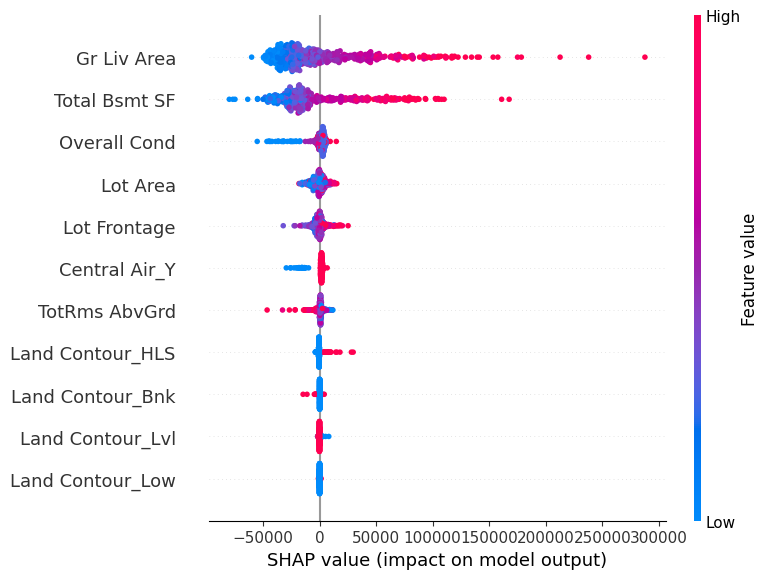

In [ ]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)

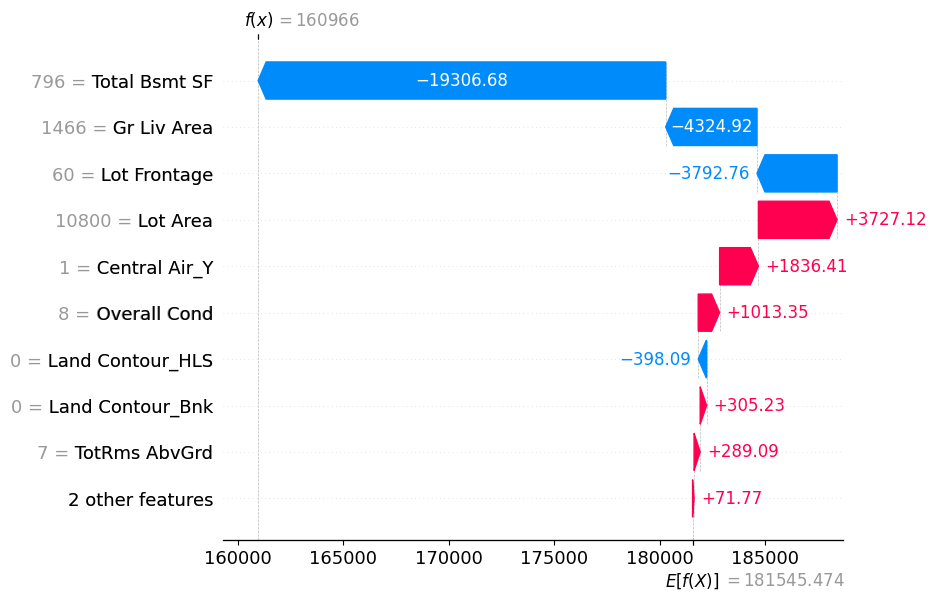

In [ ]:
shap.plots.waterfall(shap_values[0])

Gr Liv Area , total Bsmt SF , Ovreall Cond , Lot Area , Lot Frontage , and Central Air_Y are the top 6 most important features.

Gr Liv Area has a higher negative effect , total bsmt SF has a higher negative effect too but less and Ovreall Cond has the higher positive effect on the model's predictions

### Part 2

In [ ]:
df = pd.read_csv('/content/zillow_home_values-zipcode.csv')

In [ ]:
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,29022000,31032000,30042000,31052000,30062000,31072000,31082000,30092000,31102000,30112000,31122000,31012001,28022001,31032001,30042001,31052001,30062001,31072001,31082001,30092001,31102001,30112001,31122001,31012002,28022002,31032002,30042002,31052002,30062002,31072002,31082002,30092002,31102002,30112002,31122002,31012003,28022003,31032003,30042003,31052003,...,31102018,30112018,31122018,31012019,28022019,31032019,30042019,31052019,30062019,31072019,31082019,30092019,31102019,30112019,31122019,31012020,29022020,31032020,30042020,31052020,30062020,31072020,31082020,30092020,31102020,30112020,31122020,31012021,28022021,31032021,30042021,31052021,30062021,31072021,31082021,30092021,31102021,30112021,31122021,31012022,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00","107,274.00","107,076.00","107,081.00","107,112.00","107,325.00","107,480.00","107,709.00","108,092.00","108,328.00","108,782.00","109,187.00","109,242.00","109,045.00","108,514.00","108,330.00","108,390.00","108,548.00","108,693.00","108,464.00","108,504.00","108,660.00","108,944.00","109,056.00","109,176.00","109,353.00","109,930.00","110,527.00","111,058.00","111,451.00","111,944.00","112,638.00","113,249.00","113,778.00","114,116.00","114,439.00","114,716.00","114,936.00","115,268.00","115,595.00","116,009.00",...,"183,387.00","184,111.00","184,809.00","185,700.00","186,367.00","186,795.00","186,730.00","186,898.00","187,336.00","187,990.00","188,582.00","188,900.00","189,633.00","190,880.00","192,023.00","192,237.00","192,266.00","193,375.00","195,037.00","196,166.00","196,393.00","196,751.00","197,546.00","199,676.00","201,967.00","204,564.00","206,902.00","209,154.00","212,069.00","213,553.00","215,782.00","218,494.00","223,994.00","229,959.00","236,318.00","241,418.00","246,015.00","249,379.00","253,321.00","257,274.00","261,945.00","267,644.00","273,946.00","280,066.00","285,121.00","288,532.00","290,458.00","291,103.00","292,081.00","292,948.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00","222,885.00","223,602.00","224,818.00","224,384.00","224,051.00","222,942.00","223,281.00","222,886.00","223,553.00","224,715.00","226,127.00","226,742.00","226,052.00","225,191.00","224,344.00","225,654.00","227,161.00","228,329.00","228,637.00","228,208.00","228,270.00","227,805.00","226,857.00","226,276.00","225,961.00","226,847.00","227,512.00","228,610.00","229,355.00","229,220.00","228,621.00","227,252.00","226,692.00","225,896.00","226,760.00","228,102.00","229,657.00","230,436.00","230,730.00","230,932.00",...,"335,794.00","336,715.00","336,468.00","336,749.00","336,288.00","336,146.00","335,148.00","334,467.00","333,912.00","334,156.00","334,272.00","335,057.00","335,460.00","335,794.00","335,513.00","335,147.00","334,758.00","335,048.00","335,908.00","336,855.00","337,292.00","337,429.00","338,718.00","340,293.00","342,915.00","346,146.00","350,598.00","354,599.00","359,133.00","364,502.00","370,992.00","377,896.00","386,576.00","397,227.00","408,018.00","417,061.00","424,951.00","431,973.00","437,659.00","443,701.00","453,150.00","464,727.00","478,369.00","489,712.00","497,173.00","499,429.00","497,572.00","498,113.00","500,187.00","503,109.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00","90,009.00","90,042.00","90,007.00","90,027.00","89,987.00","89,972.00","89,926.00","89,397.00","88,767.00","87,904.00","87,765.00","87,719.00","87,845.00","87,409.00","87,119.00","86,687.00","86,521.00","86,289.00","86,068.00","85,909.00","85,645.00","85,499.00","85,113.00","84,858.00","84,710.00","84,940.00","85,102.00","85,365.00","85,547.00","85,936.00","86,165.00","86,468.00","86,751.00","86,989.00","87,324.00","87,443.00","87,661.00","87,664.00","87,732.00","87,812.00",

In [ ]:
## First 3 columns are id coluimns
id_vars = df.columns[:9]
id_vars

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'],
      dtype='object')

In [ ]:
## Melt the crypto data
long_df = pd.melt(df,id_vars=id_vars)
long_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,variable,value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,"107,261.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,"222,569.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,"90,009.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"188,096.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,"193,591.00"
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,"376,523.00"
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,"110,082.00"
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,"75,810.00"


In [ ]:
## Set the var_name  as "Date" and the value_name was "Currency Value"
long_df = pd.melt(df,id_vars=id_vars, var_name='Date',
                      value_name="Home Value")
long_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,"107,261.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,"222,569.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,"90,009.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"188,096.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,"193,591.00"
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,"376,523.00"
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,30112022,"110,082.00"
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,30112022,"75,810.00"


In [ ]:
long_df['Date'] = pd.to_datetime(long_df['Date'], format='%d%m%Y')

In [ ]:
long_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,"107,261.00"
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2000-01-31,"222,569.00"
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,2000-01-31,"90,009.00"
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,"188,096.00"
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,2022-11-30,"193,591.00"
7546546,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,2022-11-30,"376,523.00"
7546547,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,2022-11-30,"110,082.00"
7546548,80581,30657,51009,zip,IA,IA,Calumet,NaN,O Brien County,2022-11-30,"75,810.00"


In [ ]:
long_df = long_df.set_index('Date')
long_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,"107,261.00"
2000-01-31,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,"222,569.00"
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,"90,009.00"
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"188,096.00"
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,"275,983.00"
...,...,...,...,...,...,...,...,...,...,...
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,"193,591.00"
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,"376,523.00"
2022-11-30,82217,30657,55366,zip,MN,MN,NaN,NaN,Sibley County,"110,082.00"


In [ ]:
states = ['CA', 'WA', 'OR', 'AZ', 'NV']
new_df = long_df[(long_df['State'].isin(states)) & (long_df.index.year >= 2010) & (long_df.index.year <= 2020)]

In [ ]:
new_df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2010-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"209,250.00"
2010-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"257,372.00"
2010-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"296,430.00"
2010-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,"271,829.00"
2010-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,"156,704.00"
...,...,...,...,...,...,...,...,...,...,...
2020-12-31,98502,30657,95950,zip,CA,CA,Grimes,NaN,Colusa County,"220,881.00"
2020-12-31,95776,30657,89041,zip,NV,NV,Pahrump,"Pahrump, NV",Nye County,NaN
2020-12-31,99923,30657,98623,zip,WA,WA,White Salmon,NaN,Klickitat County,"538,209.00"


In [ ]:
import os
import subprocess
import pandas as pd

# Specify the URL of your GitHub repository
repo_url = "https://github.com/Bmdhia/Dhia-Ben-Marzouk__Belt-Exam-A.git"

# Specify the local path where you want to clone the repository
local_repo_path = "/path/to/local/clone"

# Clone the repository
subprocess.run(["git", "clone", repo_url, local_repo_path])

# Assuming you have the filtered_data DataFrame from the previous code

# Create the "Data" folder if it doesn't exist within the cloned repository
data_folder_path = f"{local_repo_path}/Data"
os.makedirs(data_folder_path, exist_ok=True)

# Specify the file path for the CSV file
csv_file_path = f"{data_folder_path}/data-for-tableau.csv"

# Save the processed data as a CSV file
new_df.to_csv(csv_file_path)

# Display a message indicating successful saving
print(f"Data has been saved to {csv_file_path}")

Data has been saved to /path/to/local/clone/Data/data-for-tableau.csv


In [ ]:
new_df.to_csv("data-for-tableau.csv")

In [ ]:
resampled_data = new_df.groupby('State').resample('YS').mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [ ]:
resampled_data

RegionID  SizeRank  RegionName  Home Value
State Date                                                   
AZ    2010-01-01 125,430.67  9,836.64   85,550.34  169,930.89
      2011-01-01 125,430.67  9,836.64   85,550.34  152,272.47
      2012-01-01 125,430.67  9,836.64   85,550.34  159,902.06
      2013-01-01 125,430.67  9,836.64   85,550.34  183,657.23
      2014-01-01 125,430.67  9,836.64   85,550.34  198,551.49
      2015-01-01 125,430.67  9,836.64   85,550.34  206,834.17
      2016-01-01 125,430.67  9,836.64   85,550.34  217,452.80
      2017-01-01 125,430.67  9,836.64   85,550.34  229,066.03
      2018-01-01 125,430.67  9,836.64   85,550.34  244,689.17
      2019-01-01 125,430.67  9,836.64   85,550.34  257,396.58
      2020-01-01 125,430.67  9,836.64   85,550.34  278,841.94
CA    2010-01-01  98,747.74  9,324.49   93,598.65  415,491.81
      2011-01-01  98,747.74  9,324.49   93,598.65  388,468.03
      2012-01-01  98,747.74  9,324.49   93,598.65  388,593.63
      2013-01-01  98,747.74  9,324.49   93,598.65  454,509.85
      2014-01-01  98,747.74  9,324.49   93,598.65  505,808.42
      2015-01-01  98,747.74  9,324.49   93,598.65  535,297.12
      2016-01-01  98,747.74  9,324.49   93,598.65  569,319.27
      2017-01-01  98,747.74  9,324.49   93,598.65  601,938.43
      2018-01-01  98,747.74  9,324.49   93,598.65  646,936.55
      2019-01-01  98,747.74  9,324.49   93,598.65  649,531.48
      2020-01-01  98,747.74  9,324.49   93,598.65  675,124.17
NV    2010-01-01 112,977.66 10,727.58   89,265.24  189,285.32
      2011-01-01 112,977.66 10,727.58   89,265.24  168,931.54
      2012-01-01 112,977.66 10,727.58   89,265.24  165,003.29
      2013-01-01 112,977.66 10,727.58   89,265.24  199,847.53
      2014-01-01 112,977.66 10,727.58   89,265.24  228,975.14
      2015-01-01 112,977.66 10,727.58   89,265.24  247,372.12
      2016-01-01 112,977.66 10,727.58   89,265.24  265,123.98
      2017-01-01 112,977.66 10,727.58   89,265.24  284,543.22
      2018-01-01 112,977.66 10,727.58   89,265.24  319,753.46
      2019-01-01 112,977.66 10,727.58   89,265.24  337,914.43
      2020-01-01 112,977.66 10,727.58   89,265.24  350,564.89
OR    2010-01-01 106,076.82 14,728.10   97,394.49  224,035.02
      2011-01-01 106,076.82 14,728.10   97,394.49  205,273.04
      2012-01-01 106,076.82 14,728.10   97,394.49  201,899.02
      2013-01-01 106,076.82 14,728.10   97,394.49  216,964.50
      2014-01-01 106,076.82 14,728.10   97,394.49  233,022.53
      2015-01-01 106,076.82 14,728.10   97,394.49  249,633.92
      2016-01-01 106,076.82 14,728.10   97,394.49  272,424.45
      2017-01-01 106,076.82 14,728.10   97,394.49  294,524.76
      2018-01-01 106,076.82 14,728.10   97,394.49  311,491.06
      2019-01-01 106,076.82 14,728.10   97,394.49  323,800.94
      2020-01-01 106,076.82 14,728.10   97,394.49  338,782.97
WA    2010-01-01  99,857.94 13,383.39   98,603.70  250,932.49
      2011-01-01  99,857.94 13,383.39   98,603.70  230,557.03
      2012-01-01  99,857.94 13,383.39   98,603.70  225,432.14
      2013-01-01  99,857.94 13,383.39   98,603.70  240,848.44
      2014-01-01  99,857.94 13,383.39   98,603.70  256,869.92
      2015-01-01  99,857.94 13,383.39   98,603.70  275,704.94
      2016-01-01  99,857.94 13,383.39   98,603.70  302,116.53
      2017-01-01  99,857.94 13,383.39   98,603.70  334,494.27
      2018-01-01  99,857.94 13,383.39   98,603.70  367,370.46
      2019-01-01  99,857.94 13,383.39   98,603.70  381,711.64
      2020-01-01  99,857.94 13,383.39   98,603.70  408,430.21

In [ ]:
df_df = resampled_data.unstack(level=0)

In [ ]:
df_df

RegionID                                           SizeRank  \
State              AZ        CA         NV         OR        WA       AZ   
Date                                                                       
2010-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2011-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2012-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2013-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2014-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2015-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2016-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2017-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2018-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2019-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   
2020-01-01 125,430.67 98,747.74 112,977.66 106,076.82 99,857.94 9,836.64   

                                                  RegionName            \
State            CA        NV        OR        WA         AZ        CA   
Date                                                                     
2010-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2011-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2012-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2013-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2014-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2015-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2016-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2017-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2018-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2019-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   
2020-01-01 9,324.49 10,727.58 14,728.10 13,383.39  85,550.34 93,598.65   

                                         Home Value                        \
State             NV        OR        WA         AZ         CA         NV   
Date                                                                        
2010-01-01 89,265.24 97,394.49 98,603.70 169,930.89 415,491.81 189,285.32   
2011-01-01 89,265.24 97,394.49 98,603.70 152,272.47 388,468.03 168,931.54   
2012-01-01 89,265.24 97,394.49 98,603.70 159,902.06 388,593.63 165,003.29   
2013-01-01 89,265.24 97,394.49 98,603.70 183,657.23 454,509.85 199,847.53   
2014-01-01 89,265.24 97,394.49 98,603.70 198,551.49 505,808.42 228,975.14   
2015-01-01 89,265.24 97,394.49 98,603.70 206,834.17 535,297.12 247,372.12   
2016-01-01 89,265.24 97,394.49 98,603.70 217,452.80 569,319.27 265,123.98   
2017-01-01 89,265.24 97,394.49 98,603.70 229,066.03 601,938.43 284,543.22   
2018-01-01 89,265.24 97,394.49 98,603.70 244,689.17 646,936.55 319,753.46   
2019-01-01 89,265.24 97,394.49 98,603.70 257,396.58 649,531.48 337,914.43   
2020-01-01 89,265.24 97,394.49 98,603.70 278,841.94 675,124.17 350,564.89   

                                  
State              OR         WA  
Date                              
2010-01-01 224,035.02 250,932.49  
2011-01-01 205,273.04 230,557.03  
2012-01-01 201,899.02 225,432.14  
2013-01-01 216,964.50 240,848.44  
2014-01-01 233,022.53 256,869.92  
2015-01-01 249,633.92 275,704.94  
2016-01-01 272,424.45 302,116.53  
2017-01-01 294,524.76 334,494.27  
2018-01-01 311,491.06 367,370.46  
2019-01-01 323,800.94 381,711.64  
2020-01-01 338,782.97 408,430.21

<Axes: xlabel='Date'>

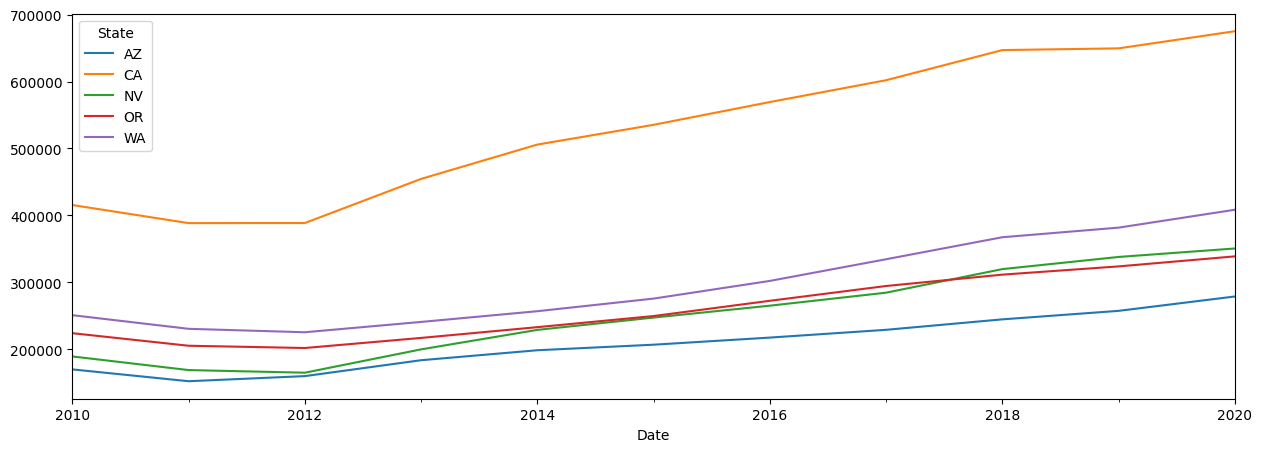

In [ ]:
plt.figure(figsize=(15, 5))
df_df['Home Value'].plot(ax=plt.gca())

# Tableau Workbook

https://public.tableau.com/shared/JJ47JGNJW?:display_count=n&:origin=viz_share_link